# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Jérémy Neveu
- date   : June 1st 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

FindCentralStar


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [17]:
!ls ../OverScanRemove/trim_images

trim_20170601_006.fits trim_20170601_062.fits trim_20170601_112.fits
trim_20170601_007.fits trim_20170601_063.fits trim_20170601_113.fits
trim_20170601_008.fits trim_20170601_064.fits trim_20170601_114.fits
trim_20170601_009.fits trim_20170601_065.fits trim_20170601_115.fits
trim_20170601_010.fits trim_20170601_066.fits trim_20170601_116.fits
trim_20170601_015.fits trim_20170601_067.fits trim_20170601_117.fits
trim_20170601_016.fits trim_20170601_068.fits trim_20170601_118.fits
trim_20170601_017.fits trim_20170601_069.fits trim_20170601_119.fits
trim_20170601_018.fits trim_20170601_070.fits trim_20170601_120.fits
trim_20170601_019.fits trim_20170601_071.fits trim_20170601_121.fits
trim_20170601_020.fits trim_20170601_072.fits trim_20170601_122.fits
trim_20170601_021.fits trim_20170601_073.fits trim_20170601_123.fits
trim_20170601_022.fits trim_20170601_074.fits trim_20170601_124.fits
trim_20170601_023.fits trim_20170601_075.fits trim_20170601_125.fits
trim_20170601_024.fits trim_201706

In [18]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=15
MAX_IMGNUMBER=39
object_name='HD185975'
SelectTagRe='^trim_20170601_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170601_[0-9]+.fits$'
NBIMGPERLROW=4

### Output directory fot fits images

In [19]:
outputdir="./cut_fitsimages"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
print input_filelist[:5]

['trim_20170601_006.fits' 'trim_20170601_007.fits' 'trim_20170601_008.fits'
 'trim_20170601_009.fits' 'trim_20170601_010.fits']


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [25]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [26]:
MakeFileList()   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [31]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [32]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

## Acces to data of  images
----------------------------------

In [33]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [34]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [35]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [36]:
#all_filt

## Show images
-----------------------

In [37]:
len(all_images)

25

In [38]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,5*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

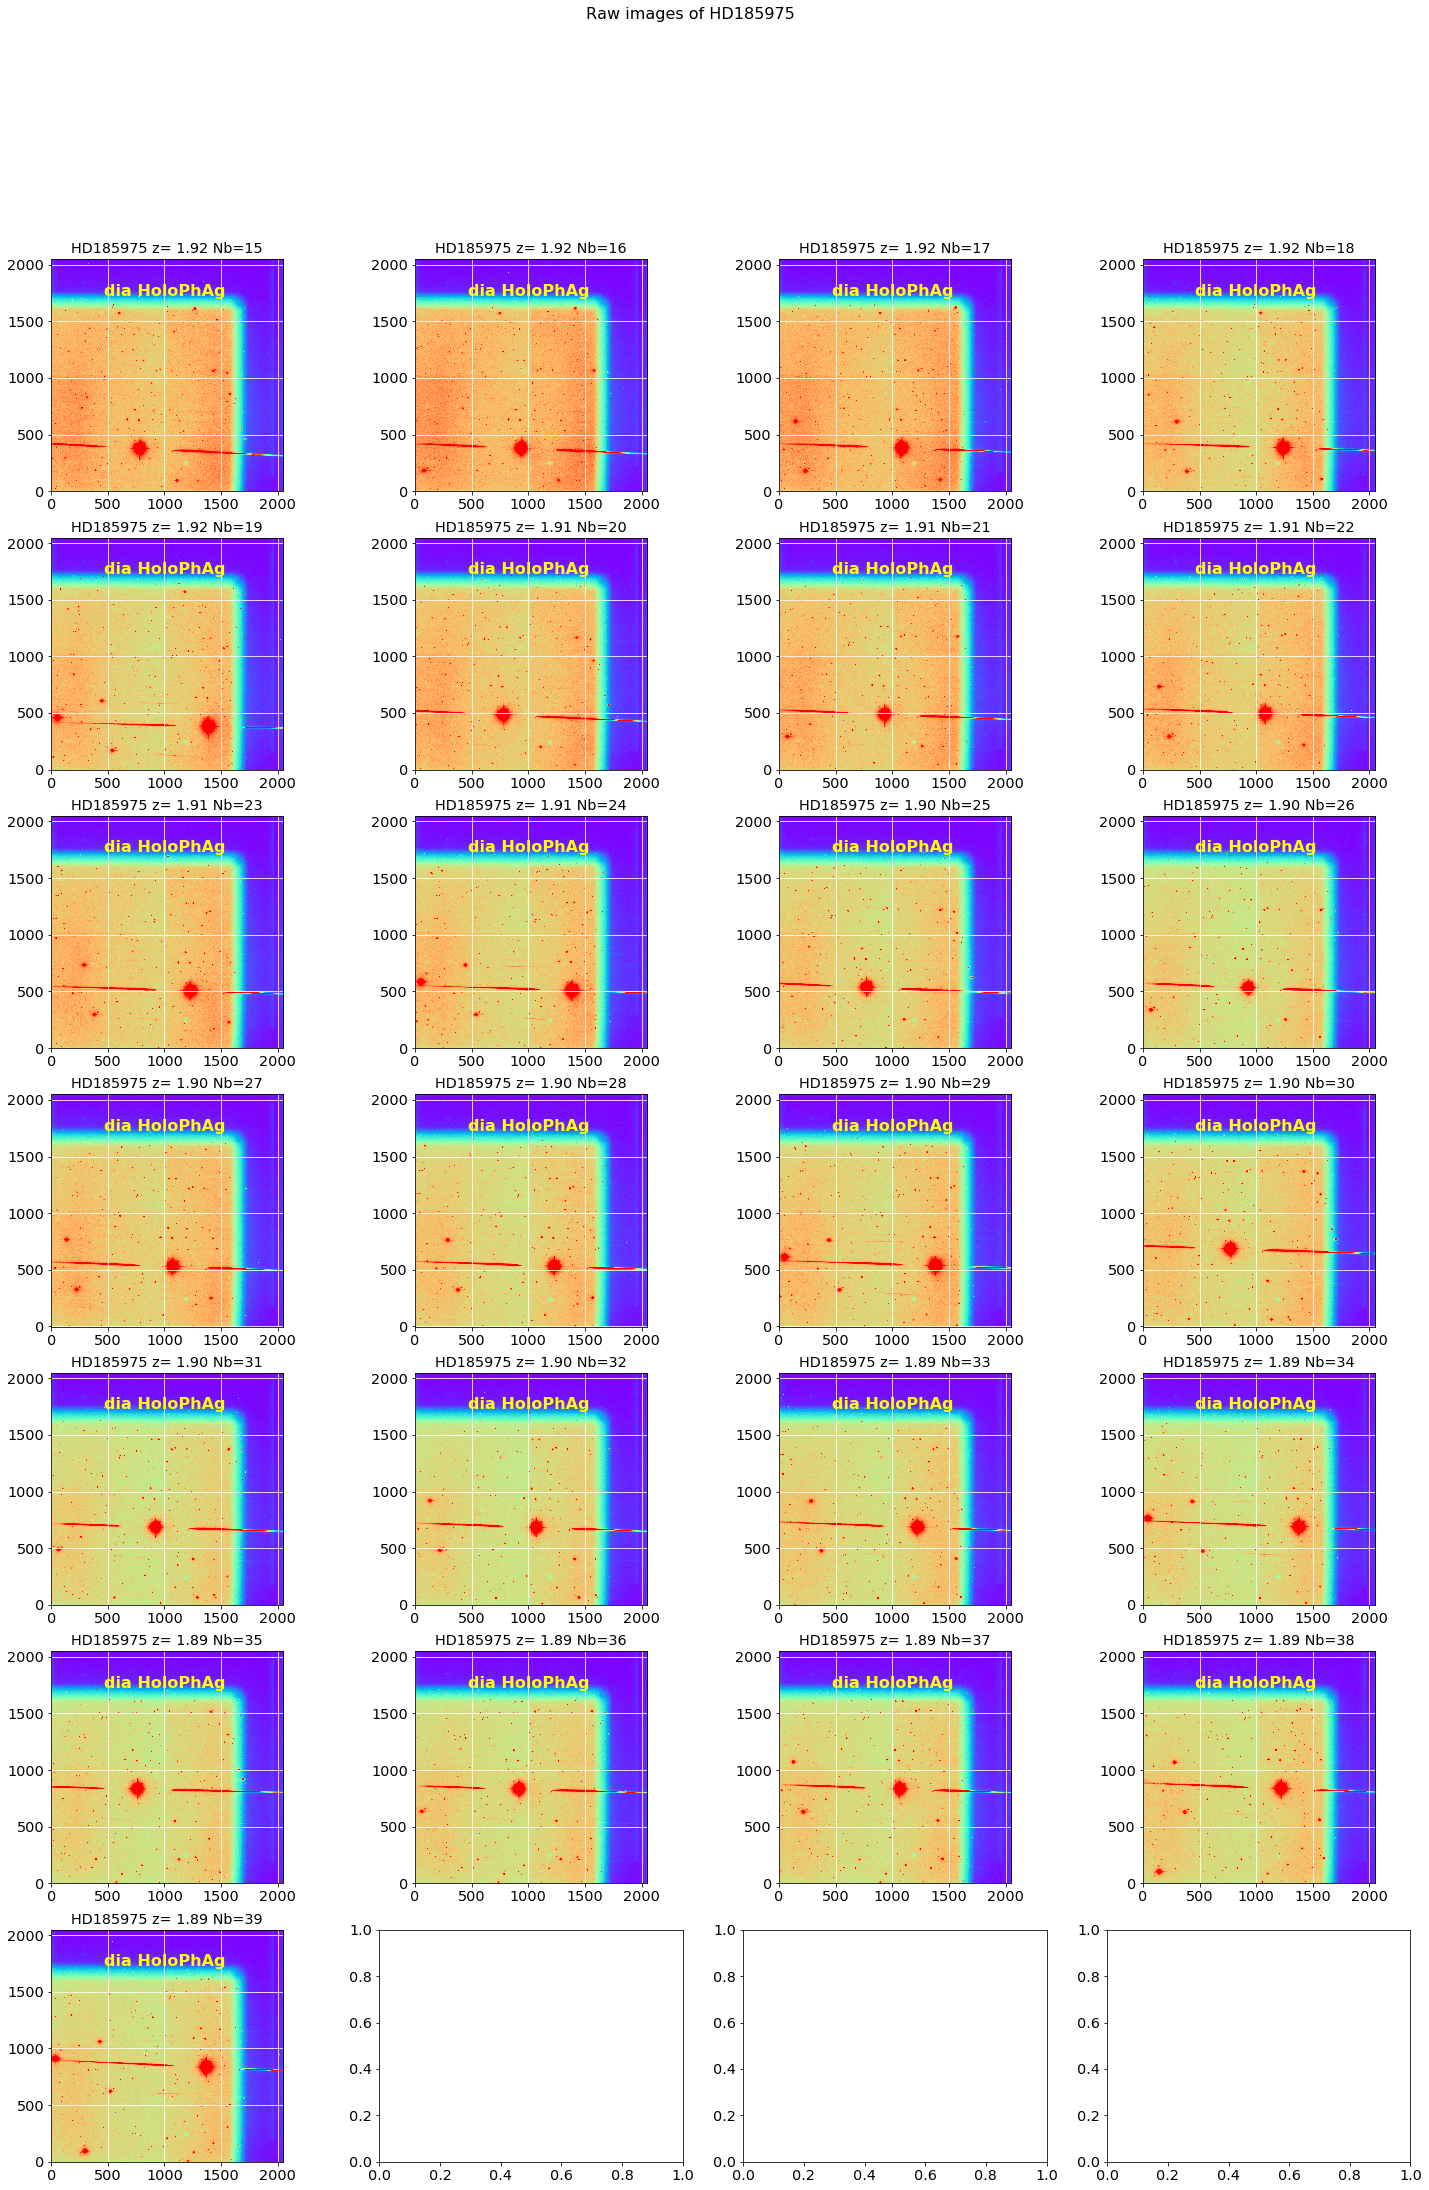

In [39]:
ShowRawImages()

### Find the star locations
----------------------------

In [82]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=8, threshold=200*std) # (JN) valeurs optimisées pour cette étude
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [83]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  412.909835799 575.0 276.136167096


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux           mag       
--- ------------- ------------- ... ------- ------------- ----------------
  1 1107.75789858  91.695564335 ... 59893.0  2.1831172792  -0.847692667651
  2 775.302718416 375.361001268 ... 60142.0 1.13080458361  -0.133468900483
  3 781.768768392 374.581475291 ... 60141.0 1.08472546416 -0.0882995885775
  4 1426.74845658 1053.70592963 ... 54374.0 1.89876656123   -0.69617893712
  5 599.355276204 1563.12120782 ... 61168.0 2.34837792042   -0.92691997116
  6 1264.47034142 1604.21286263 ... 59744.0 2.86025143629   -1.14101053089
----------------------------------------------------------------
1  mean, median, std =  418.422740148 583.0 278.725714934
 id   xcentroid     ycentroid   ...   peak       flux           mag       
--- ------------- ------------- ... ------- ------------- ----------------
  1 1262.04937414 94.6331199004 ... 60626.0 2.23484809004  -0.873120020122
  2 78.3006076538 178.774382474 ... 60133.0 2.976110

### Central star positions

In [102]:
ids = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,3,4,4,4,5,4]
x_star = []
y_star = []
for iss,s in enumerate(img_sources):
    for ss in s :
        if ss["id"] == ids[iss]:
            x_star.append(ss["xcentroid"])
            y_star.append(ss["ycentroid"])

In [103]:
positions_central = np.array([y_star, x_star]).T
print positions_central

[[  374.58147529   781.76876839]
 [  375.33391764   933.71643729]
 [  377.78598555  1086.28610916]
 [  380.42462074  1239.09575657]
 [  385.23542017  1384.35927948]
 [  485.33337838   770.5229638 ]
 [  489.57590569   929.36416016]
 [  497.45625338  1082.42679765]
 [  501.70159285  1234.35328068]
 [  507.30977955  1379.36020705]
 [  534.66086322   765.41573618]
 [  532.34212998   917.46042069]
 [  532.05734178  1078.70165837]
 [  534.34005043  1231.54340519]
 [  540.1760171   1374.78251479]
 [  687.76301311   761.04750317]
 [  685.68229465   913.40718729]
 [  682.29280554  1073.00260358]
 [  684.09533743  1225.32579387]
 [  688.43493249  1370.4328364 ]
 [  827.42987171   755.461736  ]
 [  825.92543618   914.45154233]
 [  827.35363692  1067.71067535]
 [  830.59237754  1220.63233569]
 [  835.22843367  1364.72223449]]


In [104]:
# Default position
x0 = x_star[len(img_sources)/2]
y0 = y_star[len(img_sources)/2]

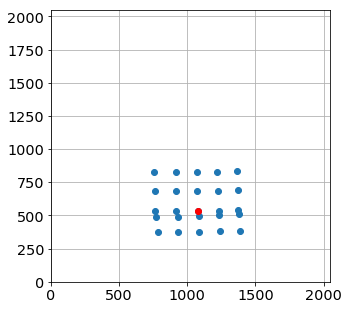

In [105]:
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x0,y0,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Cut the image

In [106]:
DeltaY=200
DeltaX=600

In [107]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

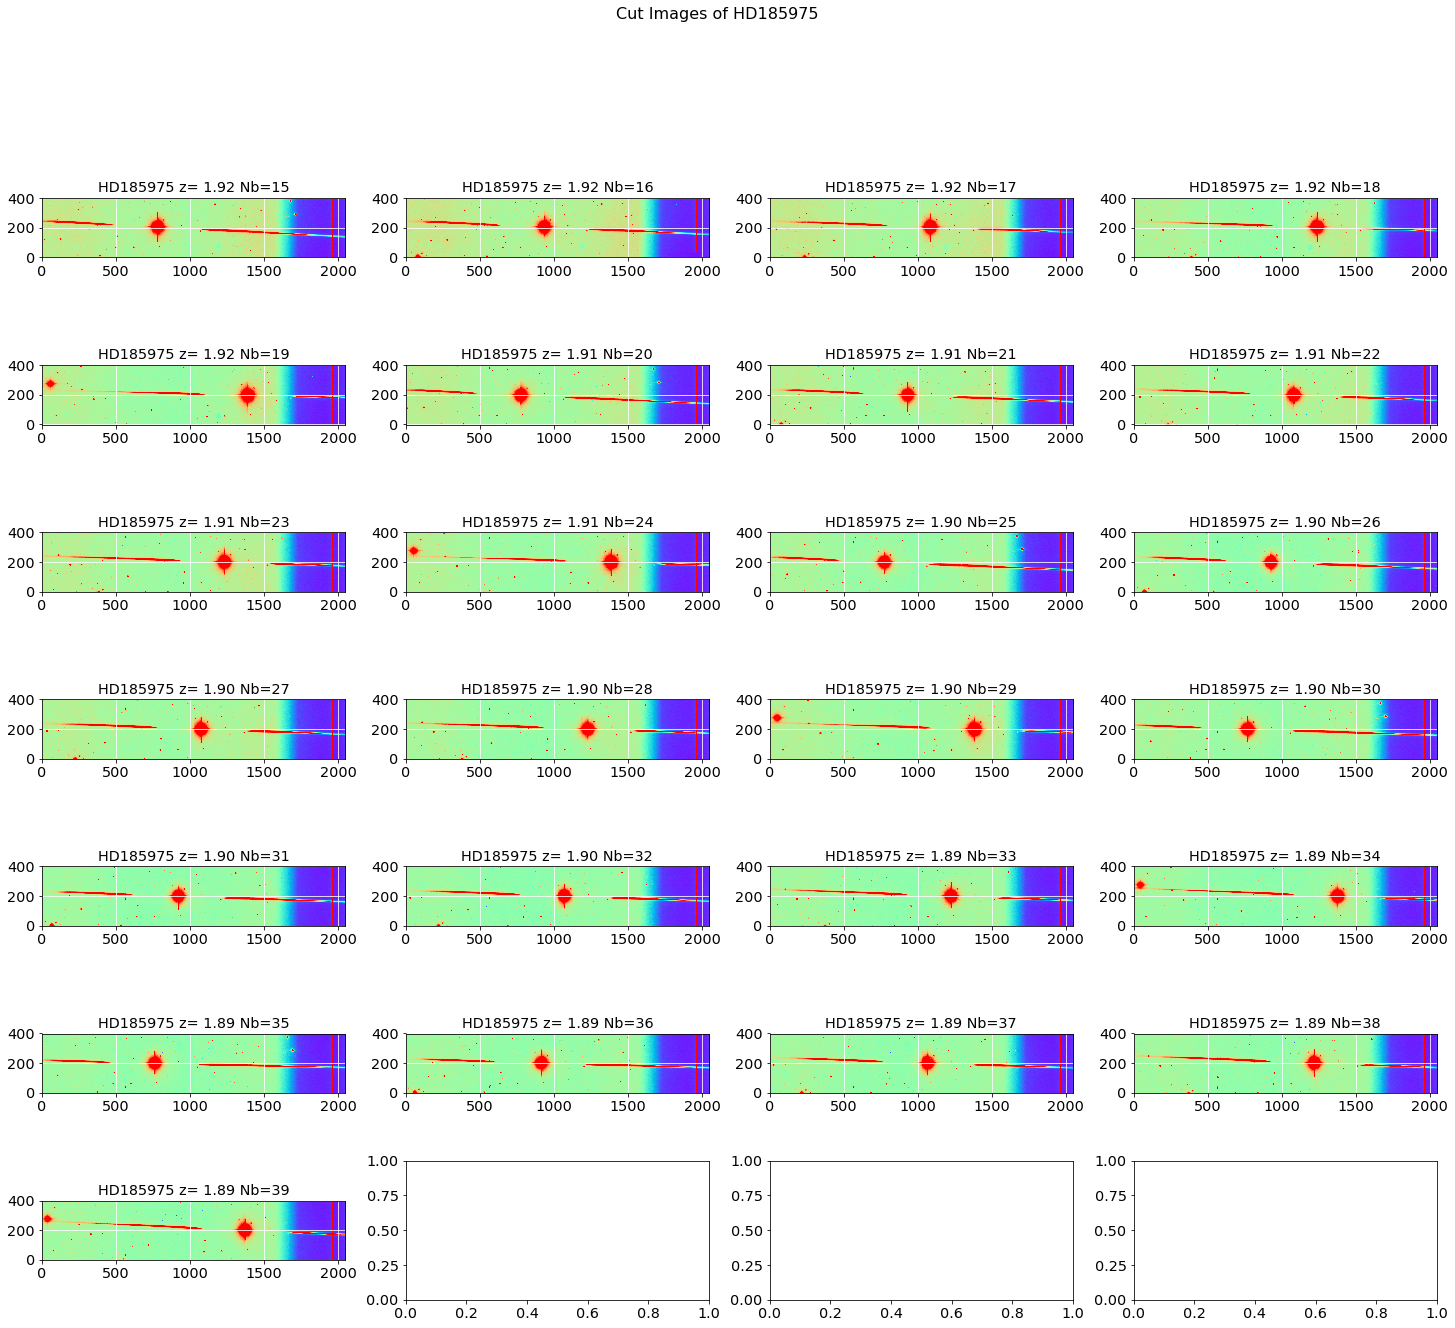

In [108]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [109]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [110]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [111]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

179


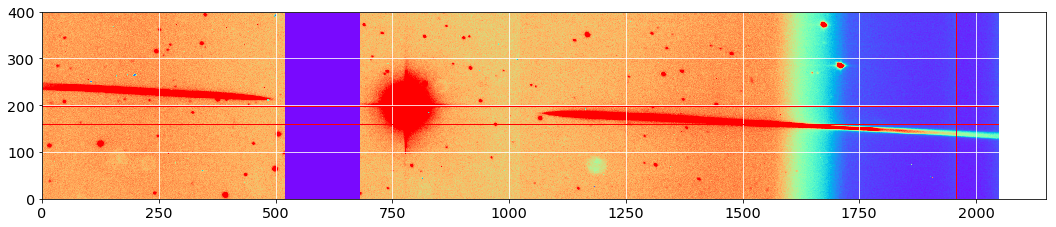

In [112]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [113]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170601_015.fits
trim_20170601_016.fits
trim_20170601_017.fits
trim_20170601_018.fits
trim_20170601_019.fits
trim_20170601_020.fits
trim_20170601_021.fits
trim_20170601_022.fits
trim_20170601_023.fits
trim_20170601_024.fits
trim_20170601_025.fits
trim_20170601_026.fits
trim_20170601_027.fits
trim_20170601_028.fits
trim_20170601_029.fits
trim_20170601_030.fits
trim_20170601_031.fits
trim_20170601_032.fits
trim_20170601_033.fits
trim_20170601_034.fits
trim_20170601_035.fits
trim_20170601_036.fits
trim_20170601_037.fits
trim_20170601_038.fits
trim_20170601_039.fits


### Save outputfilename

In [114]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

./cut_fitsimages/star_centroids.txt


In [115]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_015.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_016.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_017.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_018.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_019.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_020.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_021.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_022.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_023.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_024.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 09:02 cut_fitsimages/cutimg_20170601_025.fits
-rw-r--r--